## A/B Testing 


## Content Table
- [Introduction](#intro)
- [I - Probability](#probability)
- [II - A/B Testing](#ab_test)
- [III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project，we are looking at the result of A/B testing for an e-commerce website. The goal is to figure out if it is necessary for them to use the new website features or maintain the old one or extend the testing time before making the decision. 


<a id='probability'></a>
#### I - Probabilty

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(777)

In [5]:
# load in the data
df=pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df.shape

(294478, 5)

In [7]:
#missing data?
df.info()

#Luckily, there's not any missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# num of duplicated id
df['user_id'].duplicated().sum()

3894

In [9]:
#number of unique id
df['user_id'].nunique()

290584

In [10]:
df.shape[0]==df['user_id'].duplicated().sum()+df['user_id'].nunique()

True

In [11]:
#convert rate
df['converted'].mean()

0.11965919355605512

There are mismatches of group and landing_page in the dataset.  For example, `new_page` should be correspond to `treatment`  while `old_page` should be grouped together with `control`.
There are two types of mismatch: `new_page` was marked as `control` and `old_page` as `treatment`

In [12]:
df[df["group"]=='treatment'].shape, df.query("group=='treatment'").shape
#easier way to reach the same goal is to use .query()

((147276, 5), (147276, 5))

In [13]:
#calcualte the number of mismatch
df_treatment=df.query("group=='treatment'")
non_match_treat1=df_treatment[df_treatment['landing_page']!='new_page']


In [14]:
df_control=df.query("group=='control'")
non_match_control1=df_control[df_control['landing_page']!='old_page']

print('There are {} mismatches.'.format((non_match_treat1.shape[0]+non_match_control1.shape[0])))

There are 3893 mismatches.


Since we don't know whether the mismacthed rows have received proper treatment, we decided to drop them from the dataframe 

In [15]:
#get the new dataframe df2 with proper grouping
df_treatment=df_treatment[df_treatment['landing_page']=='new_page']
df_old_page=df.query("landing_page=='old_page'")
df_control=df_old_page[df_old_page['group']=='control']

In [16]:
df2=pd.concat([df_treatment,df_control],ignore_index=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1




a.  How many unique **user_id** are there in **df2** ? A：290584

In [17]:
#df2 number of unique user_id
df2['user_id'].nunique()

290584

b.  Duplicated **user_id** in **df2**  What's is it? A：index 1404

In [18]:
#duplicated user_id in df2
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
#Drop this duplicated row since we already have one 773192 in the data 
df2.drop(index=1404,axis=0,inplace=True)

a. Regardless of whichever page, what's the total convert rate? A：11.96%

In [21]:
# total convert rate
df2['converted'].mean()

0.11959708724499628

b. Convert rate in `control` group？A：12%

In [22]:
# convert rate in control group
control=df2[df2['group']=='control']
control['converted'].mean()

0.1203863045004612

c. Convert rate in `treatment` group？A：11.88%

In [23]:
# convert rate in treatment group
treatment=df2[df2['group']=='treatment']
treatment['converted'].mean()

0.11880806551510564

d. How likely will a user receive a new landing page? A：50.01% 

In [24]:
#probability of landing on a new page
n_new_page=df2[df2['landing_page']=='new_page'].shape[0]
p_new_page=n_new_page/df2.shape[0]
p_new_page

0.5000619442226688

In [25]:
#observed difference in convert rate
observed_diff=control['converted'].mean()-treatment['converted'].mean()
observed_diff

0.0015782389853555567

e. So far, based on current statistics, we could see small difference in convert rate between control group and treatment group and unsure about its statistical significance. It could probably just result from coincidence.

<a id='ab_test'></a>
### II - A/B Testing, Hypothesis Testing

`1.` Hypothesis

**$H_{0}$** : **$p_{old}$**-**$p_{new}$**<=0

**$H_{1}$** : **$p_{old}$** -**$p_{new}$** >0

In [26]:
# In null hypothesis both new and old convert rate are represented by total rate, 
#becasue the ultimate goal is to get p_old-p_new=0
p_new=df2['converted'].mean()
p_new

0.11959708724499628

In [27]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

 $n_{new}$ how many observations in new landing page(treatment)？ A：145310

In [28]:
n_new=treatment.shape[0]
n_new

145310

 $n_{old}$ how many observations in old landing page(control)？ A：145274

In [29]:
n_old=control.shape[0]
n_old

145274

In [30]:
#use numpy.random.choice function to simulate single group convert rate(treatment)
new_page_converted=np.random.choice([1,0],p=[p_new,1-p_new],size=n_new).mean()
new_page_converted

0.11959947698024913

In [31]:
#use numpy.random.choice function to simulate single group convert rate(control)
old_page_converted=np.random.choice([1,0],p=[p_old,1-p_old],size=n_old).mean()
old_page_converted

0.11855528174346408

One example of simulated value

In [32]:
#find one value  p_new -  p_old  , but we need more to construct a distribution
p_diff=new_page_converted-old_page_converted
p_diff

0.0010441952367850477

To simulate 10,000 $p_{new}$ - $p_{old}$ and store these values in **p_diffs** 

In [33]:
# construct null hypothesis distribution
p_diffs=[]
for e in range(10000):
    new_page_converted=np.random.choice([1,0],p=[p_new,1-p_new],size=n_new).mean()
    old_page_converted=np.random.choice([1,0],p=[p_old,1-p_old],size=n_old).mean()
    p_diff=new_page_converted-old_page_converted
    p_diffs.append(p_diff)

i. plot a **p_diffs** distibution. It looks normally distributed.

In [34]:
# convert the list into array
p_diffs=np.array(p_diffs)

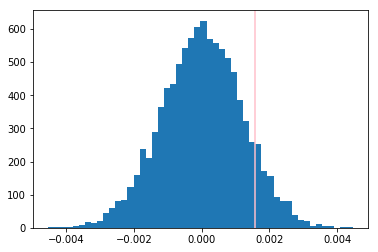

In [35]:
#plot
plt.hist(p_diffs,bins=50);
plt.axvline(observed_diff,color='pink')

Visually, it seems that the observed difference is at the right side of the critical value in the distribution.

In [36]:
#calculate p-value
(p_diffs>observed_diff).mean()

0.0957

P-value equals 0.1024 which is larger than 0.05. Therefore, we could not reject null hypothese that **$H_{0}$** : **$p_{old}$**-**$p_{new}$**>=0 . And we could not draw the conclusion there is this statistical difference in covnert rate between old and new landing page.

We could also use a built-in mechanism to get the result directly, but the things we have conduced above are important in understanding statistical significance

In [37]:
#Use statsmodels to calculate p-value, z-statistics
import statsmodels.api as sm
convert_old = control['converted'].sum()
convert_new = treatment['converted'].sum()

n_old = control.shape[0]
n_new = treatment.shape[0]

Use `stats.proportions_ztest` to calculate p-value and z-score

In [38]:
#alternative : str in ['two-sided', 'smaller', 'larger'] since here our alternative p_old-p_new>0
z_score,p_value=sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='larger')
z_score,p_value

(1.3109241984234394, 0.09494168724097551)

Z-score and p-value both tell us that the null hypothesis fails to be rejected. There's no siginificant difference in covert rate between control and treatment group.

<a id='regression'></a>
### III - Regression Analysis

`1.` In the last part，we try to get the same result as the one from A/B test  based on regression model  <br><br>

a. Since each value in the covert volumn is either 1(converted) or 0(non-converted), so we decide to use logistic regression.

b. The goal is to use **statsmodels** to fit the model mentioned in  **a.** in attempt to see if there is siginificant conversion difference between two different landing pages. However, we need to create a column for the intercept and assign to every user a virtual variable. Aside from the  **intercept** column, an **ab_page** column is established, marking users in **treatment** group as 1， **control** group as 0.

In [39]:
#append a column called intercept
df2['intercept']=1

In [40]:
#create ab_page column
ab_page_dummy=pd.get_dummies(df2['group'])
ab_page_dummy.head()

,control,treatment
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [41]:
#check datatype
ab_page_dummy.dtypes

control      uint8
treatment    uint8
dtype: object

In [42]:
#append the ab_page to df2, actually it's numeric verision of column 'group' 
df2['ab_page']=ab_page_dummy['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1



c. Use **statsmodels** fit the logistic model, summarize the model parameters and predict whether the conversion

In [43]:
#fit the data into the model
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']]).fit().summary2()
model

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-07-03 02:58 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

$log\frac{p}{1-p}=-1.9888+(-0.0150)*{ab\_page}$

The p-value for ab_page is 0.1899, which is larger than the alpha value and thus the group may not be suitable in classifying conversion. In other word, the difference in conversion between control and treatment group is mot significant.

Taking other factors into the model may be more effective in predicting the outcome but meanwhile it could bring up potential problems like multicollinearity.

Now as we try to see if the conversion was affected by region, we introduce a new dataset call countries.csv


In [44]:
#load contries.csv
df_countries=pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
#merge the data
df2=df2.merge(df_countries,on="user_id")
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [46]:
#create column CA,UK （convert the characters into numerics）
countries=pd.get_dummies(df2['country'])
countries.head()

,CA,UK,US
0,0,0,1
1,0,0,1
2,1,0,0
3,0,1,0
4,1,0,0


In [47]:
# add column CA,UK to df2
df2['CA']=countries['CA']
df2['UK']=countries['UK']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [48]:
#new model
model2=sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']]).fit().summary2()
model2

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-07-03 02:58 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

Now we have see the outcome of the model indicating that region's independent influence on conversion. It is also worth of viewing the combined effect of region and different treatment groups to see if it would have siginicant impact.

```
df2['new_CA'] = df2['ab_page'] * df2['CA']
df2['new_UK'] = df2['ab_page'] * df2['UK']
```

In [49]:
#探索页面与国家/地区的相互作用的结果 是否会影响转化率
df2['new_CA'] = df2['ab_page'] * df2['CA']
df2['new_UK'] = df2['ab_page'] * df2['UK']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,new_CA,new_UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,1,0


In [52]:
model3=sm.Logit(df2['converted'],df2[['intercept','ab_page','new_CA','new_UK','CA','UK']]).fit().summary();
model3

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        03:11:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
==============================================================================
"""

In [51]:
model4=sm.Logit(df2['converted'],df2[['intercept','ab_page','new_CA','new_UK','CA','UK']]).fit().summary2();
model4

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-07-03 03:10 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
new_CA       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
new_UK        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
==================================================================

"""

In [ ]:
结果也是，页面与国家/地区的相互作用的P值无法推翻零假设，所以，差异不显著，没有区别。